## Tecnológico de Costa Rica

### Autor: Jorge Andrés Brenes Alfaro

## Virtual_PAHM

El código desarrollado a continuación está basado en [1]. La red diseñada es la encargada de reproducir el comportamiento de entrada y salida de una planta prototipo de péndulo amortiguado a hélice (PAHM).

## Bibliotecas

In [ ]:
#!pip install wandb

In [1]:
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt

import wandb
from wandb.keras import WandbCallback

from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.backend import clear_session

import warnings
warnings.filterwarnings('ignore')

In [2]:
#wandb.login()
run = wandb.init(project = 'Virtual_PAHM',
                config = {
                    'epochs':1000,
                    'batch_size': 64,
                    'loss_function':'Adam',
                    'Architecture': 'RNN',
                    'dataset':'Propio'
                })

wandb: Currently logged in as: jorgebre98. Use `wandb login --relogin` to force relogin


## 1. Definición del modelo
Se define el espacio de estados de la planta PAHM de la siguiente forma:
$$\dot{x}(t)=A*x(t)+Bu(t)\\
y(t)=C*x(t)$$
Donde:
- A, B y C son matrices.
- x(t) es el estado en el tiempo t.
- u(t) es la entrada externa.
- y(t) es la salida.

### 1.1 Función para simular la dinámica de la planta

In [3]:
def dinamica_modelo(A,B,C,cond_inicial,input_sequence, time_steps,muestreo):
    I = np.identity(A.shape[0])
    Ad = inv(I - muestreo*A)
    Bd = Ad*muestreo*B
    Xd = np.zeros(shape=(A.shape[0],time_steps + 1)) # # Vectores de 2 x 201 / X en tiempo discreto
    Yd = np.zeros(shape=(C.shape[0],time_steps + 1)) # # Vectores de 2 x 201 / Salida en tiempo discreto
    
    for i in range(0,time_steps):
        if i==0:
            Xd[:,[i]] = cond_inicial
            Yd[:,[i]] = C*cond_inicial
            x = Ad*cond_inicial + Bd*input_sequence[i]
        else:
            Xd[:,[i]] = x
            Yd[:,[i]] = C*x
            x = Ad*x + Bd*input_sequence[i]
            
    Xd[:,[-1]] = x
    Yd[:,[-1]] = C*x
    return Xd, Yd

## Función Escalón y rampa

In [19]:
# ********************************** Step Function **********************************#
def step_function(A,t):
    u = (t >= 0)*A
    return u

# ********************************** Ramp Function **********************************#
def ramp_function(A,t):
    r = t*step_function(A,t)
    return r

### 1.2 Definición del modelo en tiempo continuo

In [40]:
A = np.matrix([[0, 1],[-0.9413, -0.149]])
B = np.matrix([[0],[0.149]])
C = np.matrix([[1, 0]])

# Definición del tiempo de muestreo
tiempo = 200
sampling = 0.2
input_seq_train = np.random.rand(tiempo,1) # Secuencia de entrada para la simulación
                                           # Es aleatoria para que sea rica en información
x0_train = np.random.rand(2,1) # Condición inicial
#input_seq = np.ones(tiempo) # Escalón
input_seq = step_function(2.5,np.arange(0,tiempo)) # Escalón
#input_seq = ramp_function(2.5,np.arange(0,tiempo))

### 1.3 Conversión a tiempo discreto y dinámica de la planta

Text(0.5, 1.0, 'Respuesta al escalón')

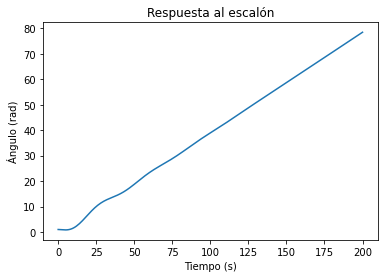

In [39]:
# Dinámica de la planta
state,output_train=dinamica_modelo(A,B,C,x0_train,input_seq,tiempo,sampling)  

plt.plot(output_train[0])
plt.xlabel('Tiempo (s)')
plt.ylabel('Ángulo (rad)')
plt.title('Respuesta al escalón')

## 2. Creación de datos

Se replica el mismo método para crear datos de entrenamiento, validación y prueba. La diferencia radica en que se hace diferentes secuencias de entrada y condiciones iniciales de planta

### 2.1 Datos de entrenamiento

In [11]:
train_label = np.reshape(output_train.T,(1,output_train.T.shape[0],1)) # Salida para el entrenamiento

input_seq_train = np.reshape(input_seq_train,(input_seq_train.shape[0],1)) # El tamaño no cambia, ¿por qué cambian los valores?
tmp_train = np.concatenate((input_seq_train, np.zeros(shape=(input_seq_train.shape[0],1))), axis=1)
tmp_train = np.concatenate((x0_train.T,tmp_train), axis=0)
train_data = np.reshape(tmp_train, (1,tmp_train.shape[0],tmp_train.shape[1])) # Entrada para el entrenamiento

### 2.2 Datos de validación

In [ ]:
input_seq_val = np.random.rand(tiempo,1)
x0_val = np.random.rand(2,1)

state_val,output_val = dinamica_modelo(A,B,C,x0_val,input_seq_val,tiempo,sampling)
val_label = np.reshape(output_val.T,(1,output_val.T.shape[0],1)) # Salida de datos de validación

input_seq_val = np.reshape(input_seq_val,(input_seq_val.shape[0],1))
tmp_val = np.concatenate((input_seq_val, np.zeros(shape=(input_seq_val.shape[0],1))), axis=1)
tmp_val = np.concatenate((x0_val.T,tmp_val), axis=0)
val_data = np.reshape(tmp_val, (1,tmp_val.shape[0],tmp_val.shape[1])) # Entrada para datos de validación

### 2.3 Datos de prueba

In [ ]:
input_seq_test = np.random.rand(tiempo,1)
x0_test = np.random.rand(2,1)

state_test,output_test = dinamica_modelo(A,B,C,x0_test,input_seq_test,tiempo,sampling)
test_label = np.reshape(output_test.T,(1,output_test.T.shape[0],1)) # Salida de datos de prueba

input_seq_test = np.reshape(input_seq_test,(input_seq_test.shape[0],1))
tmp_test = np.concatenate((input_seq_test, np.zeros(shape=(input_seq_test.shape[0],1))), axis=1)
tmp_test = np.concatenate((x0_test.T,tmp_test), axis=0)
test_data = np.reshape(tmp_test, (1,tmp_test.shape[0],tmp_test.shape[1])) # Entrada para datos de validación

## 3. Creación de la red neuronal

### 3.1 Definición del modelo

In [ ]:
clear_session()

model = Sequential()
#model.add(SimpleRNN(32, input_shape=(train_data.shape[1],train_data.shape[2]),return_sequences=True))
model.add(GRU(64, input_shape=(train_data.shape[1],train_data.shape[2]),return_sequences=True))
#model.add(LSTM(32, input_shape=(train_data.shape[1],train_data.shape[2]),return_sequences=True))
#model.add(Dense(1))
model.add(TimeDistributed(Dense(1)))  #there is no difference between this and model.add(Dense(1))...
model.compile(optimizer=Adam(), loss='mean_squared_error', metrics=['mse'])

model.summary()

### 3.2 Entrenamiento de la red

In [ ]:
history = model.fit(train_data, train_label , 
                  epochs=2000, batch_size=10, 
                  validation_data=(val_data,val_label),verbose=2)#, callbacks=[WandbCallback()])

model.save('modelo_PAHM', save_format="h5")

# use the test data to predict the model response
testPredict = model.predict(test_data)

In [ ]:
loss, accuracy = model.evaluate(test_data,test_label)
wandb.log({'evaluate/accuracy': accuracy})
wandb.run.finish()

## 4. Plot the predicted and "true" output and plot training and validation losses

In [ ]:
time_plot=range(1,tiempo+2)
plt.figure()
plt.plot(time_plot,testPredict[0,:,0], label='Real output')
plt.plot(time_plot,output_test[0,:],'r', label='Predicted output')
plt.xlabel('Discrete time steps')
plt.ylabel('Output')
plt.legend()
plt.show()

loss=history.history['loss']
val_loss=history.history['val_loss']
epochs=range(1,len(loss)+1)
plt.figure()
plt.plot(epochs, loss,'b', label='Training loss')
plt.plot(epochs, val_loss,'r', label='Validation loss')
plt.title('Training and validation losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xscale('log')
plt.legend()
plt.show()

## 5. Bibliografía
-H. Kapasi, 2022. "Modeling Non-Linear Dynamic Systems with Neural Networks", 2022. [En línea]. Disponible en: https://towardsdatascience.com/modeling-non-linear-dynamic-systems-with-neural-networks-f3761bc92649. [Accesado el 7 de marzo del 2022].